In [1]:
import os
import random
import cv2
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score         

import torch
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch import optim, nn
from torch.optim import lr_scheduler
from torchvision import models

import albumentations as A
from albumentations.pytorch import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')         

## Data preporation

Используем набор картинок, на котором уже вырезаны птицы и исправлена разметка

In [2]:
class BirdsDataset(Dataset):
    def __init__(self, ds_path: str, to_tensor: callable, cust_transforms=None):
        self.ds_path = ds_path
        # Store image path and its label
        self.imgs_path_list = [(os.path.join(self.ds_path, temp_folder, temp_img), temp_folder)
                               for temp_folder in os.listdir(self.ds_path) 
                               for temp_img in os.listdir(os.path.join(self.ds_path, temp_folder))]
        self.cust_transforms = cust_transforms
        self.to_tensor = to_tensor
    
    def __getitem__(self, ind: int):
        img_path, label = self.imgs_path_list[ind]
        
        raw_img = cv2.imread(img_path)
        
        prep_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        
        if self.cust_transforms:
            prep_img = self.cust_transforms(image=prep_img)['image']
        
        return self.to_tensor(prep_img), int(label)
    
    def __len__(self):
        return len(self.imgs_path_list)

In [3]:
trans = A.pytorch.ToTensorV2()
to_tensor = lambda x: trans(image=x)['image']

temp_ds = BirdsDataset('/kaggle/input/birds-ds/preprocessing_results', to_tensor)

In [4]:
temp_ds[0]

(tensor([[[158, 161, 163,  ..., 170, 167, 170],
          [165, 175, 182,  ..., 193, 193, 190],
          [154, 160, 163,  ..., 200, 205, 200],
          ...,
          [168, 166, 167,  ..., 158, 178, 181],
          [167, 168, 170,  ..., 172, 167, 168],
          [160, 165, 168,  ..., 167, 165, 159]],
 
         [[138, 141, 143,  ..., 156, 153, 151],
          [141, 151, 159,  ..., 174, 171, 166],
          [123, 129, 134,  ..., 168, 169, 164],
          ...,
          [130, 130, 131,  ..., 136, 157, 167],
          [135, 136, 139,  ..., 151, 148, 152],
          [131, 136, 140,  ..., 149, 147, 143]],
 
         [[ 67,  72,  82,  ...,  49,  48,  49],
          [ 79,  91, 105,  ...,  72,  72,  70],
          [ 77,  85,  94,  ...,  83,  85,  80],
          ...,
          [ 59,  56,  55,  ...,  51,  78,  94],
          [ 60,  59,  57,  ...,  58,  56,  64],
          [ 53,  56,  56,  ...,  51,  49,  47]]], dtype=torch.uint8),
 7)

## Fix Randomness
Нужно зафиксировать различные источники случайности, для воспроизводимости результатов исследования

In [5]:
RANDOM_SEED = 1234
loader_gen = torch.Generator()

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

        
def config_randomness():
    global loader_gen
    
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    loader_gen = torch.Generator()
    loader_gen.manual_seed(RANDOM_SEED)
    
    torch.cuda.manual_seed_all(RANDOM_SEED)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Training pipeline

In [6]:
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: optim.Optimizer, loss, epoch_num: int, scheduler=None):
    train_loss_history = list()
    val_loss_history = list()
    
    val_acc_history = list()
    val_metric_history = list()
    
    model.to(device)
    
    for epoch_ind in range(epoch_num):
        temp_epoch_loss = 0
        temp_val_loss = 0
        
        # Train model
        model.train()
        
        for img_batch, target_batch in train_loader:              
            img_batch = img_batch.type(torch.FloatTensor).to(device)
            target_batch = target_batch.type(torch.LongTensor).to(device)
            
            # Forward pass
            model_pred = model(img_batch)
            
            cur_loss = loss(model_pred, target_batch)
            
            # Backward pass
            optimizer.zero_grad()
            cur_loss.backward()
            optimizer.step()
            
            #print(cur_loss)
            temp_epoch_loss += cur_loss.item()
            #print(temp_epoch_loss)
            torch.cuda.empty_cache()
            
        if scheduler:
            scheduler.step()
        # Save train loss    
        train_loss_history.append(temp_epoch_loss / len(train_loader))
        
        # Validate model
        model.eval()
        
        model_answers_list = list()
        model_probs_list = list()
        true_labels_list = list()
        
        for img_batch, target_batch in val_loader:
            img_batch = img_batch.type(torch.FloatTensor).to(device)
            target_batch = target_batch.type(torch.LongTensor).to(device)
            
            model_pred = model(img_batch).detach()
            
            val_loss = loss(model_pred, target_batch)
            
            temp_val_loss += val_loss.item()
            
            model_answers_list.extend(list(torch.argmax(model_pred, dim=1).cpu().numpy()))
            model_probs_list.extend(nn.functional.softmax(model_pred.cpu(), dim=1).numpy())
            true_labels_list.extend(list(target_batch.cpu().numpy()))
            
            torch.cuda.empty_cache()
        
        val_acc_history.append(accuracy_score(true_labels_list, model_answers_list))
        val_loss_history.append(temp_val_loss / len(val_loader))
        
        model_probs_matrix = model_probs_list[0]
        
        for item in model_probs_list[1:]:
            model_probs_matrix = np.vstack((model_probs_matrix, item))      
        
        val_metric_history.append(f1_score(true_labels_list, model_answers_list, average='macro'))
        
        print(f'------------ Epoch #{epoch_ind + 1} Train loss: {round(train_loss_history[-1], 6)} Val loss: {round(val_loss_history[-1], 6)} ' + \
              f'F1: {round(val_metric_history[-1], 4)} ACC: {round(val_acc_history[-1], 4)} DIFF: {round(train_loss_history[-1] - val_loss_history[-1], 4)}   ------------')

    return train_loss_history, val_loss_history, val_acc_history, val_metric_history

In [8]:
class LogitAdjustmentLoss(nn.Module):
    def __init__(self, base_probs, tau=1.0):
        super().__init__()
        self.base_probs = base_probs
        self.tau = tau

    def forward(self, inputs, targets):
        logits = inputs + torch.log(torch.pow(self.base_probs, self.tau) + 1e-12)
        return nn.functional.cross_entropy(logits, targets)

In [9]:
base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [10]:
class AttentionBoostedModel(nn.Module):
    def __init__(self, backbone_model: nn.Module, attention_input: int, prev_linear_inp_size: int, classes_count: int, hidden_attention: int=512):
        super().__init__()
        
        self.backbone_model = nn.Sequential(
            backbone_model,
            nn.BatchNorm2d(attention_input),
            nn.Conv2d(attention_input, hidden_attention, kernel_size=1),
        )
        
        self.attention_block = nn.Sequential(
            #nn.BatchNorm2d(hidden_attention),
            nn.Conv2d(hidden_attention, hidden_attention, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_attention, hidden_attention, kernel_size=1),
            nn.Softmax2d(),
        )
        
        self.flattener = nn.Flatten(start_dim=1)
        self.avg_pooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(prev_linear_inp_size + hidden_attention, classes_count)
        )
        
    def forward(self, X: torch.Tensor):
        # Forward pass of base model
        feature_map = self.backbone_model(X)
        
        attention_map = self.attention_block(feature_map)
        # Apply attention mechanism
        prep_feature_map = feature_map + attention_map * feature_map
        
        flattened_feature_map = self.flattener(prep_feature_map)
        # Get 2d vector from the feature map
        avg_pooled = self.avg_pooling(prep_feature_map).squeeze(dim=2).squeeze(dim=2)
        
        # Add average pooled features to the flattened feature map
        flattened_feature_map = torch.cat([flattened_feature_map, avg_pooled], dim=1)
        
        return self.fc(flattened_feature_map)

In [11]:
config_randomness()

batch_size = 32
epoch_num = 15
lr = 0.0005

train_transforms_list = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224, 224),
        A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(),
        A.Rotate(15), #[0, 10, 15]
        #A.GaussianBlur(5), #[],
        #A.RandomBrightnessContrast(),
    ]
)

valid_transforms_list = A.Compose(
    [
        A.augmentations.geometric.resize.Resize(224, 224),
        A.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

# Define dataset
trans = A.pytorch.ToTensorV2()
to_tensor = lambda x: trans(image=x)['image']

train_data = BirdsDataset('/kaggle/input/birds-ds/preprocessing_results', to_tensor, train_transforms_list)

# Create a stratified train test split
ind_list = list()
labels_list = list()

for temp_ind in range(len(train_data)):
    ind_list.append(temp_ind)
    labels_list.append(train_data[temp_ind][1])
    
train_ind_list, valid_ind_list = train_test_split(ind_list, test_size=0.3, stratify=labels_list, random_state=RANDOM_SEED)

train_ds = Subset(train_data, train_ind_list)

# Turn off transforms
valid_dataset = deepcopy(train_data)
valid_dataset.cust_transforms = valid_transforms_list

valid_ds = Subset(valid_dataset, valid_ind_list)

# Create sampler with data upsampling function
uniq_labels_list, labels_count_list = np.unique(labels_list, return_counts=True)
class_weights = {uniq_labels_list[temp_ind]: sum(labels_count_list) / labels_count_list[temp_ind] for temp_ind in range(len(uniq_labels_list))}

train_ind_weight_list = [class_weights[labels_list[temp_ind]] for temp_ind in train_ind_list]
valid_ind_weight_list = [class_weights[labels_list[temp_ind]] for temp_ind in valid_ind_list]

w_train_sampler = WeightedRandomSampler(train_ind_weight_list, len(train_ind_weight_list), replacement=True, 
                                        generator=torch.Generator().manual_seed(RANDOM_SEED))
# w_valid_sampler = WeightedRandomSampler(valid_ind_weight_list, len(valild_ind_weight_list), replacement=True, 
#                                         generator=torch.Generator().manual_seed(RANDOM_SEED))

# Define Loss
loss = nn.CrossEntropyLoss()

# Calculate base probs on train dataset and use in LogitAdjustment loss 
#base_probs = [1 / item[1] for item in sorted(class_weights.items(), key=lambda x: x[0])]
#loss = LogitAdjustmentLoss(torch.FloatTensor(base_probs).to(device), tau=1.0)

# Get backbone model
backbone_model = deepcopy(base_model)
for temp_param in backbone_model.parameters():
    temp_param.requires_grad = False

# Create model with attention block from ResNet101
backbone_model = nn.Sequential(*list(backbone_model.children())[:-2])
attention_input = backbone_model[-1][-1][-2].num_features
prev_linear_input_size = 25088# base_model.fc.in_features

model = AttentionBoostedModel(backbone_model, attention_input, prev_linear_input_size, classes_count=len(uniq_labels_list))

train_loader = DataLoader(train_ds, batch_size, num_workers=2, sampler=w_train_sampler, 
                          worker_init_fn=seed_worker, generator=loader_gen)
# train_loader = DataLoader(train_ds, batch_size, num_workers=2, shuffle=True, 
#                           worker_init_fn=seed_worker, generator=loader_gen)
val_loader = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2)    

optimizer = optim.Adam(model.parameters(), lr, weight_decay=0.005)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

torch.cuda.empty_cache()

In [12]:
%%time

train_loss_history, val_loss_history, val_acc_history, val_metric_history = train(model, train_loader, val_loader, 
                                                                                  optimizer, loss, epoch_num, scheduler)

------------ Epoch #1 Train loss: 3.675357 Val loss: 3.438491 F1: 0.1729 ACC: 0.2044 DIFF: 0.2369   ------------
------------ Epoch #2 Train loss: 1.894129 Val loss: 2.369208 F1: 0.2514 ACC: 0.3923 DIFF: -0.4751   ------------
------------ Epoch #3 Train loss: 1.057736 Val loss: 2.062377 F1: 0.3936 ACC: 0.5193 DIFF: -1.0046   ------------
------------ Epoch #4 Train loss: 0.898106 Val loss: 1.977877 F1: 0.393 ACC: 0.5138 DIFF: -1.0798   ------------
------------ Epoch #5 Train loss: 0.76211 Val loss: 1.856306 F1: 0.4345 ACC: 0.547 DIFF: -1.0942   ------------
------------ Epoch #6 Train loss: 0.663917 Val loss: 1.831849 F1: 0.4119 ACC: 0.5414 DIFF: -1.1679   ------------
------------ Epoch #7 Train loss: 0.63462 Val loss: 1.818866 F1: 0.4529 ACC: 0.5801 DIFF: -1.1842   ------------
------------ Epoch #8 Train loss: 0.683572 Val loss: 1.836691 F1: 0.4478 ACC: 0.5635 DIFF: -1.1531   ------------
------------ Epoch #9 Train loss: 0.599552 Val loss: 1.847157 F1: 0.4262 ACC: 0.558 DIFF: -1.

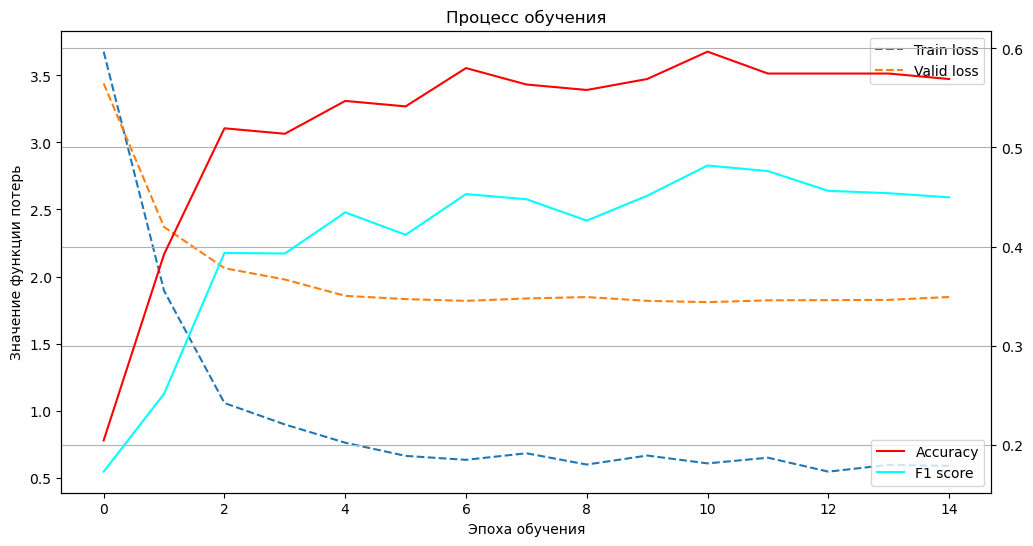

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.set_title('Процесс обучения')
ax.set_xlabel('Эпоха обучения')
ax.set_ylabel('Значение функции потерь')

ax.plot(train_loss_history, '--', label='Train loss')
ax.plot(val_loss_history, '--', label='Valid loss')
ax.legend()

sec_ax = ax.twinx()
sec_ax.plot(val_acc_history, label='Accuracy', color='red')
sec_ax.plot(val_metric_history, label='F1 score', color='cyan')

sec_ax.legend(loc='lower right')
sec_ax.grid()